Download the dataset

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip 
!unzip data.zip 

--2019-04-08 08:59:04--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.142.115, 13.249.142.107, 13.249.142.26, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.142.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.4’

data.zip.4          100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2019-04-08 08:59:04 (42.5 MB/s) - ‘data.zip.4’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt  

In [0]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [0]:
import random

# divide data into 20% validation and 80% training
category_lines_train = {}
category_lines_val = {}
for key in category_lines.keys():
  random.shuffle(category_lines[key])
  splitpoint = int(len(category_lines[key]) * 0.2)
  category_lines_val[key] = category_lines[key][:splitpoint]
  category_lines_train[key] = category_lines[key][splitpoint:]

Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [0]:
import torch.nn as nn

# Linear hidden units
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
# Gated recurrent units (GRU)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

In [0]:
# Long short term memory units (LSTM)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.LSTMCell(input_size + hidden_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hc = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hc)
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [0]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [11]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden = gru(input[0], hidden)
output, next_hidden, next_cell = lstm(input[0], hidden, cell)
print(output)

tensor([[-2.9139, -2.9336, -2.8442, -2.9018, -2.9482, -2.9658, -2.8479, -2.9222,
         -2.9438, -2.9207, -2.8690, -2.9333, -2.8526, -2.7974, -2.8788, -2.8545,
         -2.9135, -2.8063]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 13)


We will also want a quick way to get a training example (a name and its
language):




In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

'''
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
'''

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    
def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

category = Spanish / line = Salinas
category = Dutch / line = Haanrath
category = Spanish / line = Agramunt
category = German / line = Fuhrmann
category = Scottish / line = Murphy
category = Italian / line = Dinapoli
category = Arabic / line = Wasem
category = Italian / line = Altimari
category = English / line = Hume
category = Korean / line = Jeon


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [0]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()
  
def train_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()
  
def train_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def test(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    return output, loss.item()
  
def test_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    return output, loss.item()
  
def test_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidde,cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




Linear hidden units

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

val_loss = 0
val_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test(category_tensor_test, line_tensor_test)
    val_loss += loss2

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        val_losses.append(val_loss / plot_every)
        current_loss = 0
        val_loss = 0

5000 5% (0m 27s) 3.1198 Garcia / Japanese ✗ (Portuguese)
10000 10% (0m 54s) 4.1880 Uno / Chinese ✗ (Japanese)
15000 15% (1m 21s) 0.9076 Kasprzak / Polish ✓
20000 20% (1m 48s) 0.7289 Pezos / Greek ✓
25000 25% (2m 15s) 1.9210 Knepp / Dutch ✗ (German)
30000 30% (2m 41s) 1.8963 Fabbro / Portuguese ✗ (Italian)
35000 35% (3m 8s) 0.5955 Weeber / German ✓
40000 40% (3m 35s) 1.4412 Glynatsis / Scottish ✗ (Greek)
45000 45% (4m 2s) 2.6094 Havlice / English ✗ (Czech)
50000 50% (4m 29s) 4.6322 Althuis / Greek ✗ (Dutch)
55000 55% (4m 56s) 0.8021 Yatsenko / Russian ✓
60000 60% (5m 23s) 0.1708 Belitsky / Russian ✓
65000 65% (5m 50s) 1.0246 Gulyashko / Japanese ✗ (Russian)
70000 70% (6m 17s) 1.5374 Kuffel / German ✗ (Czech)
75000 75% (6m 44s) 0.9340 Chin / Korean ✓
80000 80% (7m 11s) 1.3781 Sokolof / Polish ✓
85000 85% (7m 38s) 0.5216 Gronchi / Italian ✓
90000 90% (8m 5s) 1.2256 Dopita / Czech ✓
95000 95% (8m 32s) 0.0691 Silvestri / Italian ✓
100000 100% (8m 59s) 3.2066 Tobias / Greek ✗ (French)


GRU hidden units

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss_gru = 0
all_losses_gru = []

val_loss_gru = 0
val_losses_gru = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss_gru += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test_gru(category_tensor_test, line_tensor_test)
    val_loss_gru += loss2

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_gru.append(current_loss_gru / plot_every)
        val_losses_gru.append(val_loss_gru / plot_every)
        current_loss_gru = 0
        val_loss_gru = 0

5000 5% (0m 57s) 2.7649 Muir / German ✗ (Scottish)
10000 10% (1m 54s) 2.5344 Choshi / Italian ✗ (Japanese)
15000 15% (2m 51s) 2.6833 Birkin / Scottish ✗ (Russian)
20000 20% (3m 49s) 2.1020 Andel / Dutch ✓
25000 25% (4m 46s) 2.4604 Ganem / Dutch ✗ (Arabic)
30000 30% (5m 43s) 1.3915 Huan / Vietnamese ✗ (Chinese)
35000 35% (6m 40s) 2.2438 O'Kelly / English ✗ (Irish)
40000 40% (7m 38s) 3.3940 Salazar / Arabic ✗ (Portuguese)
45000 45% (8m 35s) 0.1499 Abdurakhmanov / Russian ✓
50000 50% (9m 31s) 1.3667 Colbert / Dutch ✗ (French)
55000 55% (10m 27s) 0.2523 Filipowski / Polish ✓
60000 60% (11m 24s) 3.3022 Hout / French ✗ (Dutch)
65000 65% (12m 20s) 1.5379 Belo / Portuguese ✓
70000 70% (13m 19s) 1.2596 Tong / Korean ✗ (Vietnamese)
75000 75% (14m 16s) 0.6903 Hofwegen / Dutch ✓
80000 80% (14m 47s) 2.0897 Klerkse / English ✗ (Dutch)
85000 85% (15m 17s) 1.6831 Marion / Scottish ✗ (French)
90000 90% (15m 51s) 0.6152 O'Halloran / Irish ✓
95000 95% (16m 29s) 2.6718 De filippis / Greek ✗ (Italian)
1000

LSTM hidden units

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss_lstm = 0
all_losses_lstm = []

val_loss_lstm = 0
val_losses_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss_lstm += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test_lstm(category_tensor_test, line_tensor_test)
    val_loss_lstm += loss2

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_lstm.append(current_loss_lstm / plot_every)
        val_losses_lstm.append(val_loss_lstm / plot_every)
        current_loss_lstm = 0
        val_loss_lstm = 0

5000 5% (1m 8s) 2.8520 Chaim / Arabic ✗ (Chinese)
10000 10% (2m 16s) 2.8071 Kate / French ✗ (Japanese)
15000 15% (3m 24s) 3.0181 Chi / Italian ✗ (Korean)
20000 20% (4m 32s) 2.1506 Belo / Portuguese ✓
25000 25% (5m 40s) 2.6917 Slejtr / German ✗ (Czech)
30000 30% (6m 47s) 1.4364 Maurer / German ✓
35000 35% (7m 54s) 1.8520 Blaise / French ✓
40000 40% (9m 1s) 1.7377 Sartre / French ✓
45000 45% (10m 9s) 1.4716 Mui / Chinese ✓
50000 50% (11m 16s) 0.4563 Demetrious / Greek ✓
55000 55% (12m 23s) 1.6862 Shiba / Japanese ✓
60000 60% (13m 30s) 1.1389 Hofwegen / Dutch ✓
65000 65% (14m 37s) 0.9983 Duerr / German ✓
70000 70% (15m 44s) 3.2405 Stepan / Irish ✗ (Czech)
75000 75% (16m 52s) 0.9833 Mclain / Irish ✓
80000 80% (17m 59s) 1.6532 Didevich / Irish ✗ (Russian)
85000 85% (19m 6s) 2.1169 Riese / French ✗ (German)
90000 90% (20m 14s) 1.8428 Zubizarreta / Czech ✗ (Spanish)
95000 95% (21m 21s) 1.0972 Pefanis / Greek ✓
100000 100% (22m 28s) 0.3328 Oh  / Korean ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




Linear hidden units

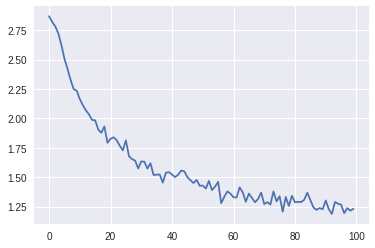

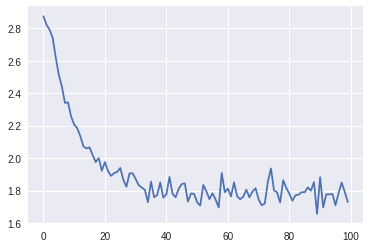

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.figure()
plt.plot(val_losses)

In [20]:
print("Final validation loss for RNN is: %f" % val_losses[-1])

Final validation loss for RNN is: 1.728535


GRU hidden units

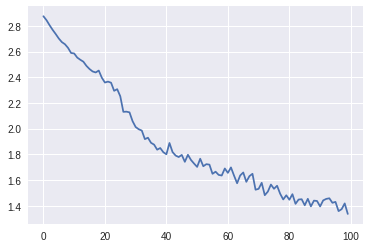

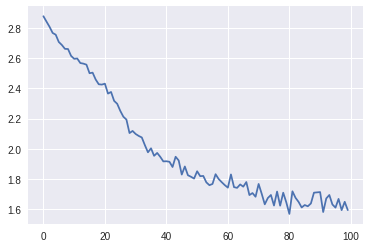

In [21]:
plt.figure()
plt.plot(all_losses_gru)
plt.figure()
plt.plot(val_losses_gru)

In [22]:
print("Final validation loss for GRU is: %f" % val_losses_gru[-1])

Final validation loss for GRU is: 1.593747


LSTM hidden units

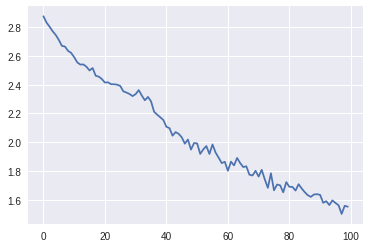

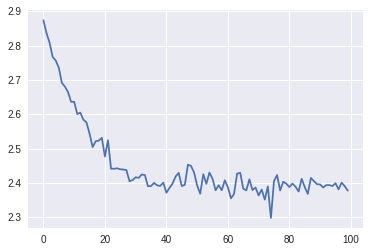

In [23]:
plt.figure()
plt.plot(all_losses_lstm)
plt.figure()
plt.plot(val_losses_lstm)

In [24]:
print("Final validation loss for LSTM is: %f" % val_losses_lstm[-1])

Final validation loss for LSTM is: 2.378113


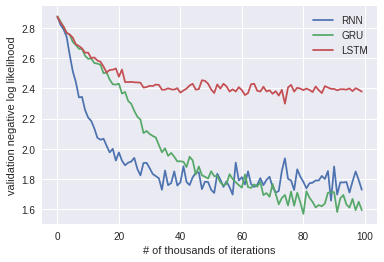

In [25]:
plt.figure()
plt.title('validation loss')
plt.plot(val_losses, label='RNN')
plt.plot(val_losses_gru, label='GRU')
plt.plot(val_losses_lstm, label='LSTM')
plt.xlabel("# of thousands of iterations")
plt.ylabel("validation negative log likelihood")
plt.legend()

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




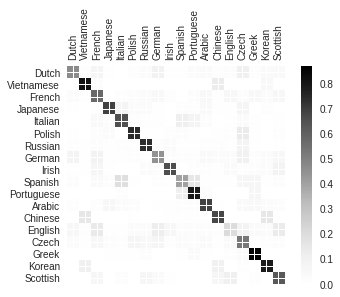

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.50) Russian
(-1.09) Czech
(-3.99) Polish

> Jackson
(-1.29) Russian
(-1.37) English
(-1.71) Czech

> Satoshi
(-1.34) Arabic
(-1.35) Portuguese
(-1.46) Japanese


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


